In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspec = inspect(engine)
columns = inspec.get_columns('measurement')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspec.get_columns('station')
for column in columns:
    print(column['name'], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Calculate the date 1 year ago from the last data point in the database
lastdate = dt.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], '%Y-%m-%d').date()
firstdate = lastdate - dt.timedelta(days=364)
print(firstdate, lastdate)

2016-08-24 2017-08-23


In [13]:
#Flask API wrk
def year_temps(start_date, end_date):
    """Returns a dictionaary min, avg, and max temps for each date in range"""
    temps_raw = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
    
    temps = {}
    
    for temp in temps_raw:
        temps[temp[0]] = {'min' : temp[0], 'avg' : temp[0], 'max' : temp[0]}
        
    return(temps)

In [14]:
# Query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= firstdate).filter(Measurement.date <= lastdate).order_by(Measurement.date.asc()).limit(5).all()

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22)]

In [15]:
# Saving the query results as a Pandas DF and set the index to the date column
prcp_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= firstdate).filter(Measurement.date <= lastdate).all())
prcp_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [16]:
# Sort the df by date
prcp_df.sort_values('date', inplace=True)
prcp_df.rename(columns={'date': 'Date', 'prcp' : 'Precipitation'}, inplace=True)
prcp_df.set_index('Date', inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


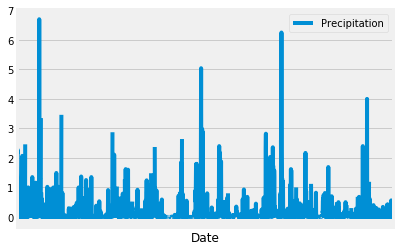

In [17]:
# Using Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(xticks=[])

In [18]:
# Using Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
#query to find the best dates based on precipitation
low_prcp = prcp_df.sort_values(by='Precipitation')
low_prcp.head(5)

,Precipitation
Date,
2017-02-15,0.0
2016-12-25,0.0
2016-12-25,0.0
2017-03-15,0.0
2017-03-14,0.0


In [20]:
# Design a query to show how many stations are available

# returns just an integer
session.query(Station.id).count()


9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == station_activity[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

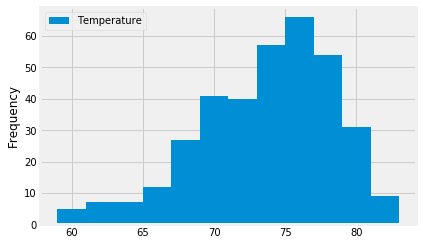

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.station, func.count(Measurement.tobs))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.tobs).desc()).limit(1).all()[0][0]


last_temp_date = dt.datetime.strptime(session.query(func.max(Measurement.date))\
                                      .filter(Measurement.station == temp_station).all()[0][0], '%Y-%m-%d').date()
first_temp_date = last_temp_date - dt.timedelta(days=364)
#print(first_temp_date, last_temp_date)

temp_df = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)\
                       .filter(Measurement.date >= first_temp_date)\
                       .filter(Measurement.date <= last_temp_date)\
                       .filter(Measurement.station == temp_station).all())

temp_df.sort_values('date', inplace=True)
temp_df.rename(columns={'date': 'Date', 'tobs' : 'Temperature'}, inplace=True)
temp_df.set_index('Date', inplace=True)
temp_df.plot(kind='hist', bins=12)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
def get_ref_dates(start_date, end_date):
    """matching dates that we have data for
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    """
    
    # adjust the query dates to be within the dataset
    early_date = dt.datetime.strptime(session.query(func.min(Measurement.date)).all()[0][0], '%Y-%m-%d').date()
    late_date = dt.datetime.strptime(session.query(func.max(Measurement.date)).all()[0][0], '%Y-%m-%d').date()
    #print(early_date, late_date)
    
    req_start = dt.datetime.strptime(start_date,'%Y-%m-%d').date()
    req_end = dt.datetime.strptime(end_date,'%Y-%m-%d').date()
    
    range_days = req_end - req_start
    
    while req_start < early_date:
        req_start = dt.date(day=req_start.day, month=req_start.month, year=req_start.year + 1)
    
    req_end = req_start + range_days
        
    while req_end > late_date:
        req_end = dt.date(day=req_end.day, month=req_end.month, year=req_end.year - 1)
    
    req_start = req_end - range_days
    
    start_date = req_start.strftime('%Y-%m-%d')
    end_date = req_end.strftime('%Y-%m-%d')
    
    return start_date, end_date

In [26]:
start = '2017-03-03'
end = '2017-03-14'
print(calc_temps(*get_ref_dates(start, end)))

[(62.0, 71.05479452054794, 82.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2017-03-03'
end = '2017-03-14'
print(calc_temps(*get_ref_dates(start, end)))


[(62.0, 71.05479452054794, 82.0)]


In [29]:
start = '2005-03-03'
end = '2005-03-14'
print(calc_temps(*get_ref_dates(start, end)))

[(62.0, 69.53932584269663, 76.0)]


In [30]:
start = '2021-03-03'
end = '2021-03-14'
print(calc_temps(*get_ref_dates(start, end)))

[(62.0, 71.05479452054794, 82.0)]


In [31]:
start = '2021-03-03'
end = '2021-03-14'
temps = calc_temps(*get_ref_dates(start, end))

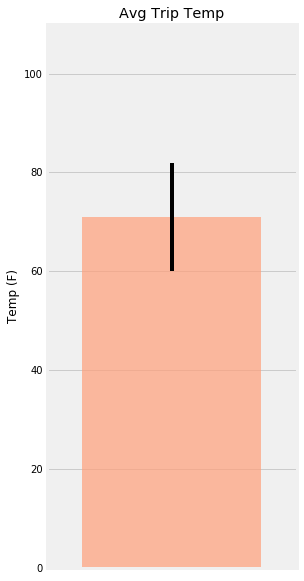

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,10))
plt.bar(1, temps[0][1], 
        tick_label='', 
        yerr=temps[0][2]-temps[0][1], 
        color='lightsalmon',  
        alpha=0.7)
plt.title("Avg Trip Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 110)
plt.grid(axis='x')
plt.margins(x=.2)
plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rain_per_station(start_date, end_date):
    total_rain = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
    .group_by(Measurement.station).filter(Measurement.date >= start_date)\
    .filter(Measurement.station == Station.station)\
    .filter(Measurement.date <= end_date)\
    .order_by(func.sum(Measurement.prcp).desc())
    
    #for station in total_rain:
        #print(station)
    
    return([record for record in total_rain])
    
start = '2015-03-03'
end = '2015-03-14'
Test = rain_per_station(*get_ref_dates(start, end))
print(Test)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 3.1399999999999992), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.3), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.72), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.67), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.65), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.33000000000000007), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.19), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]


## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


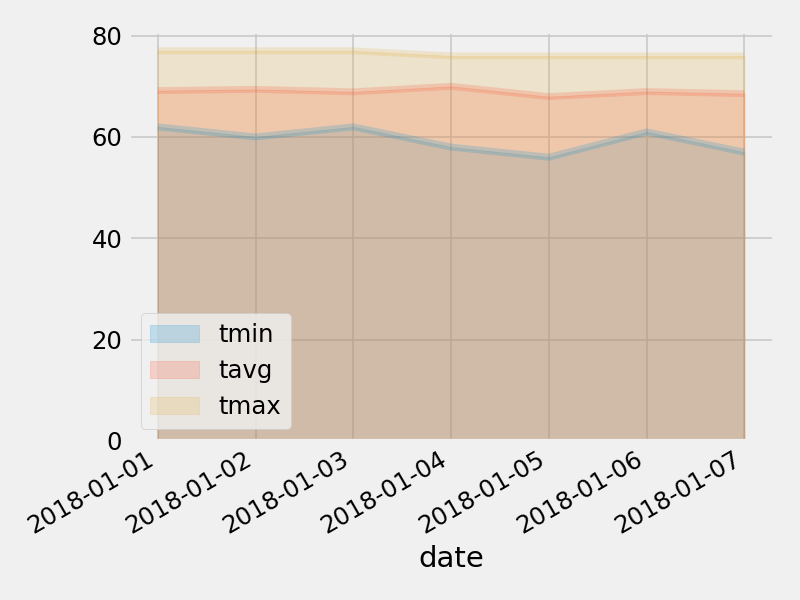

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
